In [4]:
#
#  Here we build a _predictive_ (as opposed to descriptive) model for tips
#  based on some basic features. I consider here a regression framework and
#  used boosted tree as my regression model. 
#
#  I employ here firstly a restricted set of features. One _could_ use DOLocationID,
#  trip_duration, etc, to achieve a better results. However, from the perspective
#  taxi driver, this information is not known before deciding to pick up a passenger.
#  Thus, I try to use here only features that could be known _at prediction time_. 
#
#  Nonetheless, it is interesting to know which other features give predictive power
#  and I therefore also consider as an afterthought a model with a more informative
#  feature set.
#

In [5]:
import xgboost as xgb
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
mpl.rcParams['figure.figsize'] = (10, 8)

In [3]:
# read in trip data
yellow = pd.read_csv(
    'tripdata_2018-01_PROCESSED.csv',
    parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime']
)

# read in effective region labels
eff_ids = pd.read_csv('effective_location_clusters.csv')

# merge effective region label
yellow = yellow.merge(eff_ids, left_on='PULocationID', right_on='LocationID')
del yellow['LocationID']

# shuffle training data
yellow = yellow.sample(frac=1)
yellow.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,...,trip_type,ehail_fee,color,trip_duration,normalized_tip_time,normalized_tip_amount,center_x,center_y,EffectiveLocationID,Counts
1906673,2,2018-01-07 04:14:19,2018-01-07 04:29:28,5,4.58,1,N,186,166,16.0,...,NaN,NaN,yellow,15.150000,0.228383,0.216250,986466.843610,212006.400532,66.0,209542
4049049,2,2018-01-13 22:22:57,2018-01-13 22:39:50,3,4.71,1,N,79,33,16.5,...,NaN,NaN,yellow,16.883333,0.210859,0.215758,987995.435823,204054.852578,25.0,197237
4916375,1,2018-01-26 13:26:48,2018-01-26 13:39:29,1,1.60,1,N,211,90,9.5,...,NaN,NaN,yellow,12.683333,0.161629,0.215789,983642.823666,202871.232080,68.0,54639
359505,1,2018-01-29 19:30:56,2018-01-29 19:39:30,1,1.20,1,N,239,238,7.5,...,NaN,NaN,yellow,8.566667,0.175097,0.200000,988910.634079,225197.867507,81.0,166901
5784552,1,2018-01-10 14:41:19,2018-01-10 15:10:39,1,9.50,1,N,230,138,31.0,...,NaN,NaN,yellow,29.333333,0.238636,0.225806,988595.728251,216022.344626,73.0,187263


In [6]:
#
# tansform time features for GBRT to use
#
yellow['PUHour'] = yellow.tpep_pickup_datetime.dt.hour
yellow['PUDOW'] = yellow.tpep_pickup_datetime.dt.dayofweek

In [17]:
# optional: filter outliers to avoid overfitting
yellow = yellow[yellow.normalized_tip_time < 0.5]

# Restricted (Realistic) Feature Set

In [18]:
#
#  Set up train and test data. First, only features that could be known at or
#  before pickup time.
#
features = ['PUHour', 'PUDOW', 'PULocationID', 'RatecodeID', 'passenger_count']
target = 'normalized_tip_time'

train_test_split = int(0.9*len(yellow))

train_feats = yellow.iloc[:train_test_split][features].as_matrix()
train_target = yellow.iloc[:train_test_split][target].as_matrix()

train = xgb.DMatrix(train_feats, label=train_target, feature_names=features)

test_feats = yellow.iloc[train_test_split:][features].as_matrix()
test_target = yellow.iloc[train_test_split:][target].as_matrix()

test = xgb.DMatrix(test_feats, label=test_target, feature_names=features)

/home/privitera/education/env3/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/privitera/education/env3/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/home/privitera/education/env3/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/home/privitera/education/env3/lib/python3.5/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [19]:
# train GBRT

training_parameters = {
    'min_leaf_size':100
}

model = xgb.train(
    training_parameters,
    train,
    num_boost_round=10,
    evals=[(train, 'train'), (test, 'test')]
)

[17:21:15] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[17:21:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:0.229486	test-rmse:0.229551
[17:21:21] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:0.173578	test-rmse:0.173635
[17:21:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:0.138077	test-rmse:0.138126
[17:21:26] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:0.116792	test-rmse:0.116834
[17:21:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:0.104643	test-rmse:

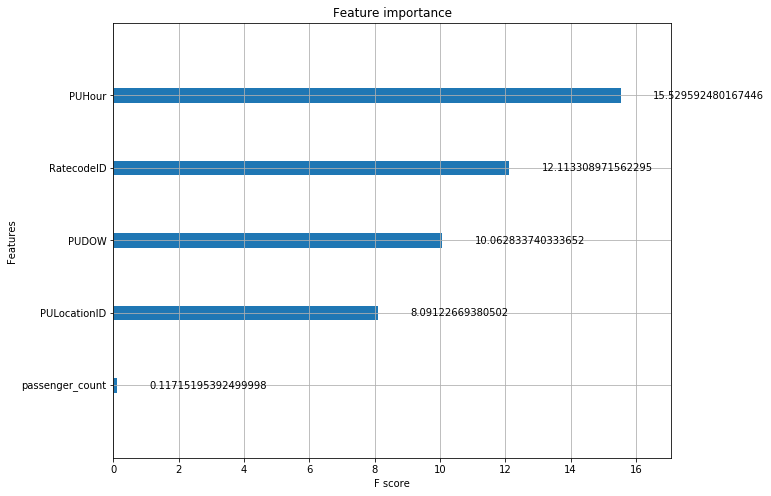

In [20]:
xgb.plot_importance(model, importance_type='gain')

Text(0, 0.5, 'actual tip')

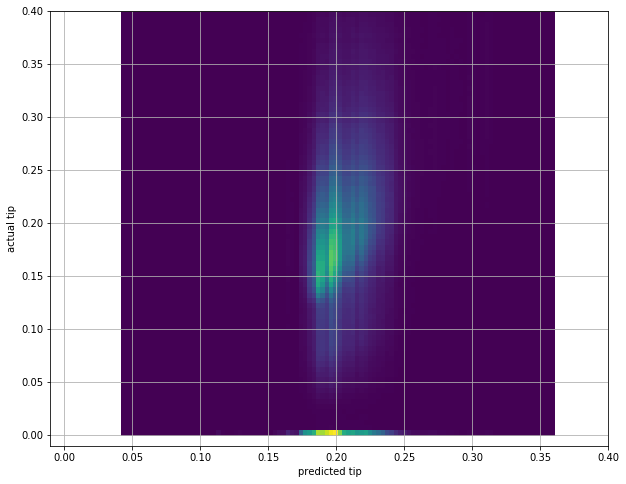

In [24]:
#
# train data: the inability to fit the train data shows that the features
# do not contain sufficient predictive power
#
plt.hist2d(model.predict(train), train.get_label(), bins=100)
plt.xlim([-0.01 , 0.4])
plt.ylim([-0.01 , 0.4])
plt.gca().grid()
plt.xlabel('predicted tip')
plt.ylabel('actual tip')

Text(0, 0.5, 'actual tip')

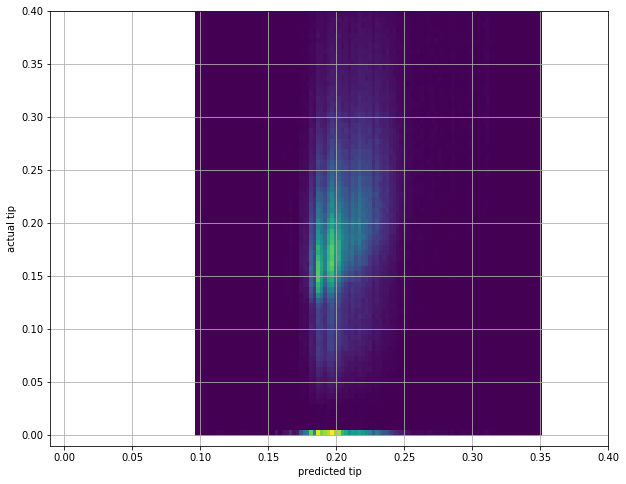

In [25]:
#
# test data
#
plt.hist2d(model.predict(test), test.get_label(), bins=100)

plt.xlim([-0.01 , 0.4])
plt.ylim([-0.01 , 0.4])
plt.gca().grid()
plt.xlabel('predicted tip')
plt.ylabel('actual tip')

# Cheating Model

In [26]:
features = ['PUHour', 'PUDOW', 'DOLocationID',
            'PULocationID', 'RatecodeID', 'passenger_count', 
            'trip_distance', 'trip_duration']
target = 'normalized_tip_time'

train_test_split = int(0.9*len(yellow))

train_feats = yellow.iloc[:train_test_split][features].as_matrix()
train_target = yellow.iloc[:train_test_split][target].as_matrix()

train = xgb.DMatrix(train_feats, label=train_target, feature_names=features)

test_feats = yellow.iloc[train_test_split:][features].as_matrix()
test_target = yellow.iloc[train_test_split:][target].as_matrix()

test = xgb.DMatrix(test_feats, label=test_target, feature_names=features)

/home/privitera/education/env3/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/privitera/education/env3/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/privitera/education/env3/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/home/privitera/education/env3/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [27]:
training_parameters = {
    'min_leaf_size':100
}

model = xgb.train(
    training_parameters,
    train,
    num_boost_round=10,
    evals=[(train, 'train'), (test, 'test')]
)

[17:24:46] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[17:24:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:0.22655	test-rmse:0.226612
[17:24:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:0.167695	test-rmse:0.167749
[17:25:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:0.129337	test-rmse:0.129393
[17:25:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:0.105427	test-rmse:0.105483
[17:25:16] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[4]	train-rmse:0.091403	test-rmse:0

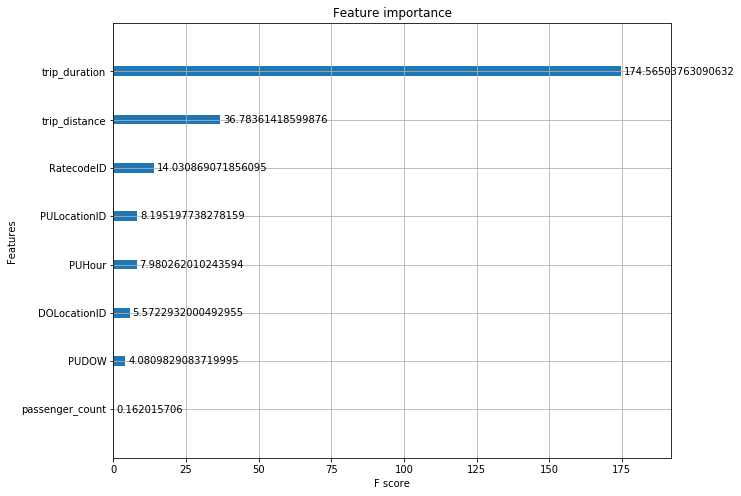

In [28]:
xgb.plot_importance(model, importance_type='gain')

Text(0, 0.5, 'actual tip')

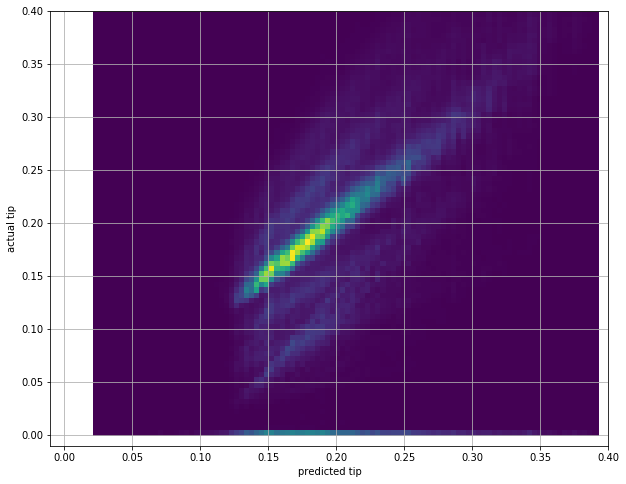

In [29]:
#
# train data: here we see a less-biased linear relationship, indicating that
# having the additional information here really helps prediction
#
plt.hist2d(model.predict(train), train.get_label(), bins=100)
plt.xlim([-0.01 , 0.4])
plt.ylim([-0.01 , 0.4])
plt.gca().grid()
plt.xlabel('predicted tip')
plt.ylabel('actual tip')

Text(0, 0.5, 'actual tip')

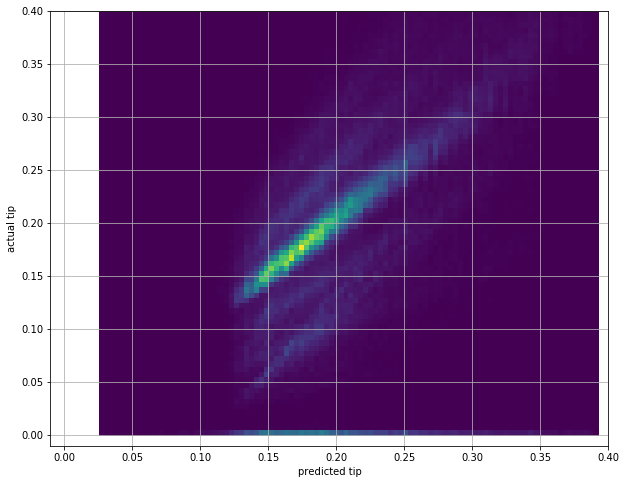

In [30]:
#
# test data indicate no signs of overfitting
#
plt.hist2d(model.predict(test), test.get_label(), bins=100)
plt.xlim([-0.01 , 0.4])
plt.ylim([-0.01 , 0.4])
plt.gca().grid()
plt.xlabel('predicted tip')
plt.ylabel('actual tip')